## Test cross-correlations on Harper DAS data

Ethan Williams

2023-03-18

In [30]:
%matplotlib inline
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend, filtfilt, butter

In [136]:
class simple_xc:
    
    def __init__(self,fdir,flist):
        self.flist = [os.path.join(fdir,fname) for fname in flist]
        self.nf = len(self.flist)
        return
    
    def set_parameters(self,pdict):
        self.srcx = pdict['srcx']
        self.recmin = pdict['recmin']
        self.recmax = pdict['recmax']
        self.nns = pdict['nns']
        self.fmin = pdict['fmin']
        self.fmax = pdict['fmax']
        self.whiten = pdict['whiten']
        self.onebit = pdict['onebit']
        with h5py.File(os.path.join(fdir,flist[0]),'r') as fp:
            self.dx = fp['Acquisition'].attrs['SpatialSamplingInterval']
            self.fs = fp['Acquisition']['Raw[0]'].attrs['OutputDataRate']
            self.nx = fp['Acquisition']['Raw[0]'].attrs['NumberOfLoci']
            self.ns = len(fp['Acquisition']['Raw[0]']['RawDataTime'][:])
        x = np.arange(nx)*dx
        r1 = int(np.argmin(abs(x-self.recmin)))
        r2 = int(np.argmin(abs(x-self.recmax)))
        self.recid = np.arange(r1,r2+1)
        self.srcid = int(np.argmin(abs(x-self.srcx))) - r1
        self.nc = len(self.recid)
        self.nw = self.nns//2 + 1
        self.nwin = int(self.ns//self.nns)
        self.spxc = np.zeros((self.nc,self.nw),dtype=np.complex_)
        self.lags = np.arange(-self.nns//2,self.nns//2)/fs
        self.offset = (self.recid - min(self.recid) - self.srcid) * self.dx
        return
    
    def preprocess_tr(self):
        self.tr = detrend(self.tr,axis=1)
        #self.tr *= np.tile(np.hamming(self.nns),(self.nc,1))
        #b, a = butter(8,(self.fmin/(self.fs/2),self.fmax/(self.fs/2)),'bandpass')
        #self.tr = filtfilt(b,a,self.tr,axis=1)
        self.sp = np.fft.rfft(self.tr,axis=1)
        return
    
    def whiten_tr(self):
        i1 = int(np.ceil(self.fmin/(self.fs/self.nns)))
        i2 = int(np.ceil(self.fmax/(self.fs/self.nns)))
        self.sp[:,i1:i2] = np.exp(1j*np.angle(self.sp[:,i1:i2]))
        self.sp[:,:i1] = np.cos(np.linspace(np.pi/2,np.pi,i1))**2 * \
                                 np.exp(1j*np.angle(self.sp[:,:i1]))
        self.sp[:,i2:] = np.cos(np.linspace(np.pi,np.pi/2,self.nw-i2))**2 *\
                                 np.exp(1j*np.angle(self.sp[:,i2:]))
        return
    
    def onebit_tr(self):
        self.tr = np.fft.irfft(self.sp,axis=1)
        self.tr = np.sign(self.tr)
        self.sp = np.fft.rfft(self.tr,axis=1)
        return
    
    def process_file(self,fname):
        with h5py.File(fname,'r') as fp:
            self.data = fp['Acquisition']['Raw[0]']['RawData'][:,self.recid].T
        for iwin in range(self.nwin):
            self.tr = self.data[:,iwin*self.nns:(iwin+1)*self.nns]
            self.preprocess_tr()
            if self.whiten:
                self.whiten_tr()
            if self.onebit:
                self.onebit_tr()
            self.spxc += self.sp * np.tile(np.conj(self.sp[self.srcid,:]),(self.nc,1))
        return
        
    def compute_xc(self,pdict):
        self.set_parameters(pdict)
        for ii, fname in enumerate(self.flist):
            print('File %d/%d' % (ii+1,self.nf))
            self.process_file(fname)
        self.spxc /= self.nf * self.nwin
        self.trxc = np.fft.irfft(self.spxc,axis=1)
        self.trxc = np.concatenate((self.trxc[:,self.nns//2:],self.trxc[:,:self.nns//2]),axis=1)
        #b, a = butter(8,(self.fmin/(self.fs/2),self.fmax/(self.fs/2)),'bandpass')
        #self.trxc = filtfilt(b,a,self.trxc,axis=1)
        return

In [137]:
fdir = '/Volumes/PeatDAS/harper_test_data'
flist = os.listdir(fdir)

pdict = {'srcx': 180, 'recmin': 100, 'recmax': 350, 'nns': 2**13, \
        'fmin': 1, 'fmax': 10, 'whiten': True, 'onebit': False}

xc = simple_xc(fdir,flist)
xc.compute_xc(pdict)


File 1/60
File 2/60
File 3/60
File 4/60
File 5/60
File 6/60
File 7/60
File 8/60
File 9/60
File 10/60
File 11/60
File 12/60
File 13/60
File 14/60
File 15/60
File 16/60
File 17/60
File 18/60
File 19/60
File 20/60
File 21/60
File 22/60
File 23/60
File 24/60
File 25/60
File 26/60
File 27/60
File 28/60
File 29/60
File 30/60
File 31/60
File 32/60
File 33/60
File 34/60
File 35/60
File 36/60
File 37/60
File 38/60
File 39/60
File 40/60
File 41/60
File 42/60
File 43/60
File 44/60
File 45/60
File 46/60
File 47/60
File 48/60
File 49/60
File 50/60
File 51/60
File 52/60
File 53/60
File 54/60
File 55/60
File 56/60
File 57/60
File 58/60
File 59/60
File 60/60


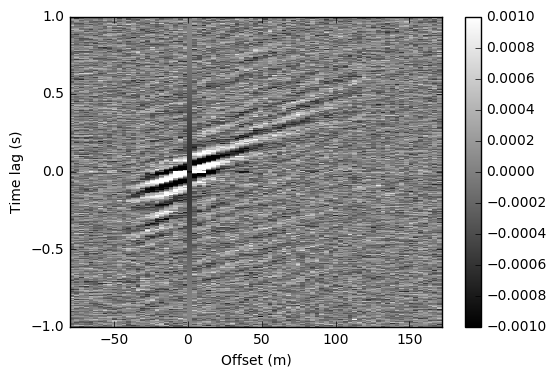

In [149]:
plt.figure(); v = 0.001
plt.pcolormesh(xc.offset,xc.lags,xc.trxc.T,vmin=-v,vmax=v,cmap='gray')
plt.xlim([min(xc.offset),max(xc.offset)])
plt.ylim([-1,1])
plt.xlabel('Offset (m)')
plt.ylabel('Time lag (s)')
plt.colorbar()

In [173]:
idx = np.logical_and(xc.offset>=0,xc.offset<=120)
shot = xc.trxc[idx,:]
off = xc.offset[idx]
lag = xc.lags
shotf = np.fft.rfft(shot,axis=1)

vs = np.linspace(100,800,50)
nv = len(vs)
ns = len(lag)
nx = len(off)
frq = np.fft.rfftfreq(ns,d=1./fs)
disp = np.zeros((nv,ns//2+1))
for iv in range(nv):
    shift = shotf.copy()
    for ix in range(nx):
        shift[ix,:] *= np.exp(2j*np.pi*frq*off[ix]/vs[iv])
    disp[iv,:] = abs(np.mean(np.real(shift),axis=0))


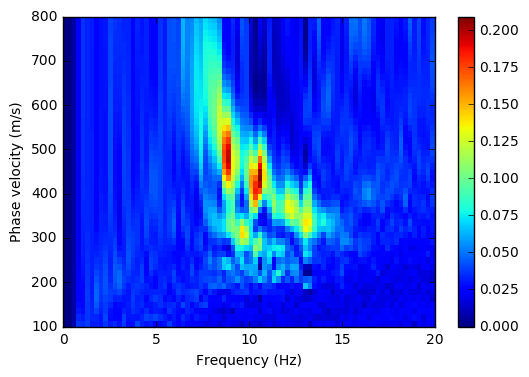

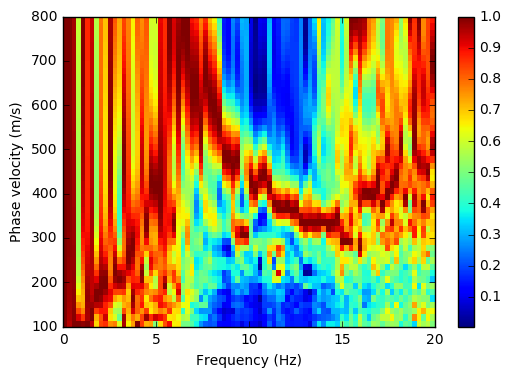

In [175]:
plt.figure()
plt.pcolormesh(frq,vs,disp)
plt.xlim([0,20])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase velocity (m/s)')
plt.colorbar()

# can also normalize
disp /= np.tile(np.max(disp,axis=0),(nv,1))

plt.figure()
plt.pcolormesh(frq,vs,disp)
plt.xlim([0,20])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase velocity (m/s)')
plt.colorbar()